In [11]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  

In [12]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [14]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [15]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\nefer\AppData\Local\Temp\ipykernel_2108\3601434573.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [16]:
# Print all of the classes mapped to the Base
classes = Base.classes.keys()
print(classes)

['station', 'measurement']


In [17]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
measurement = Base.classes.measurement
station = Base.classes.station

In [18]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
rec = session.query(measurement.date).order_by(measurement.date.desc()).first()
rec_ = rec[0]
rec__ = datetime.strptime(rec_, '%Y-%m-%d')
rec_date = rec__.strftime('%Y-%m-%d')
rec_date

'2017-08-23'

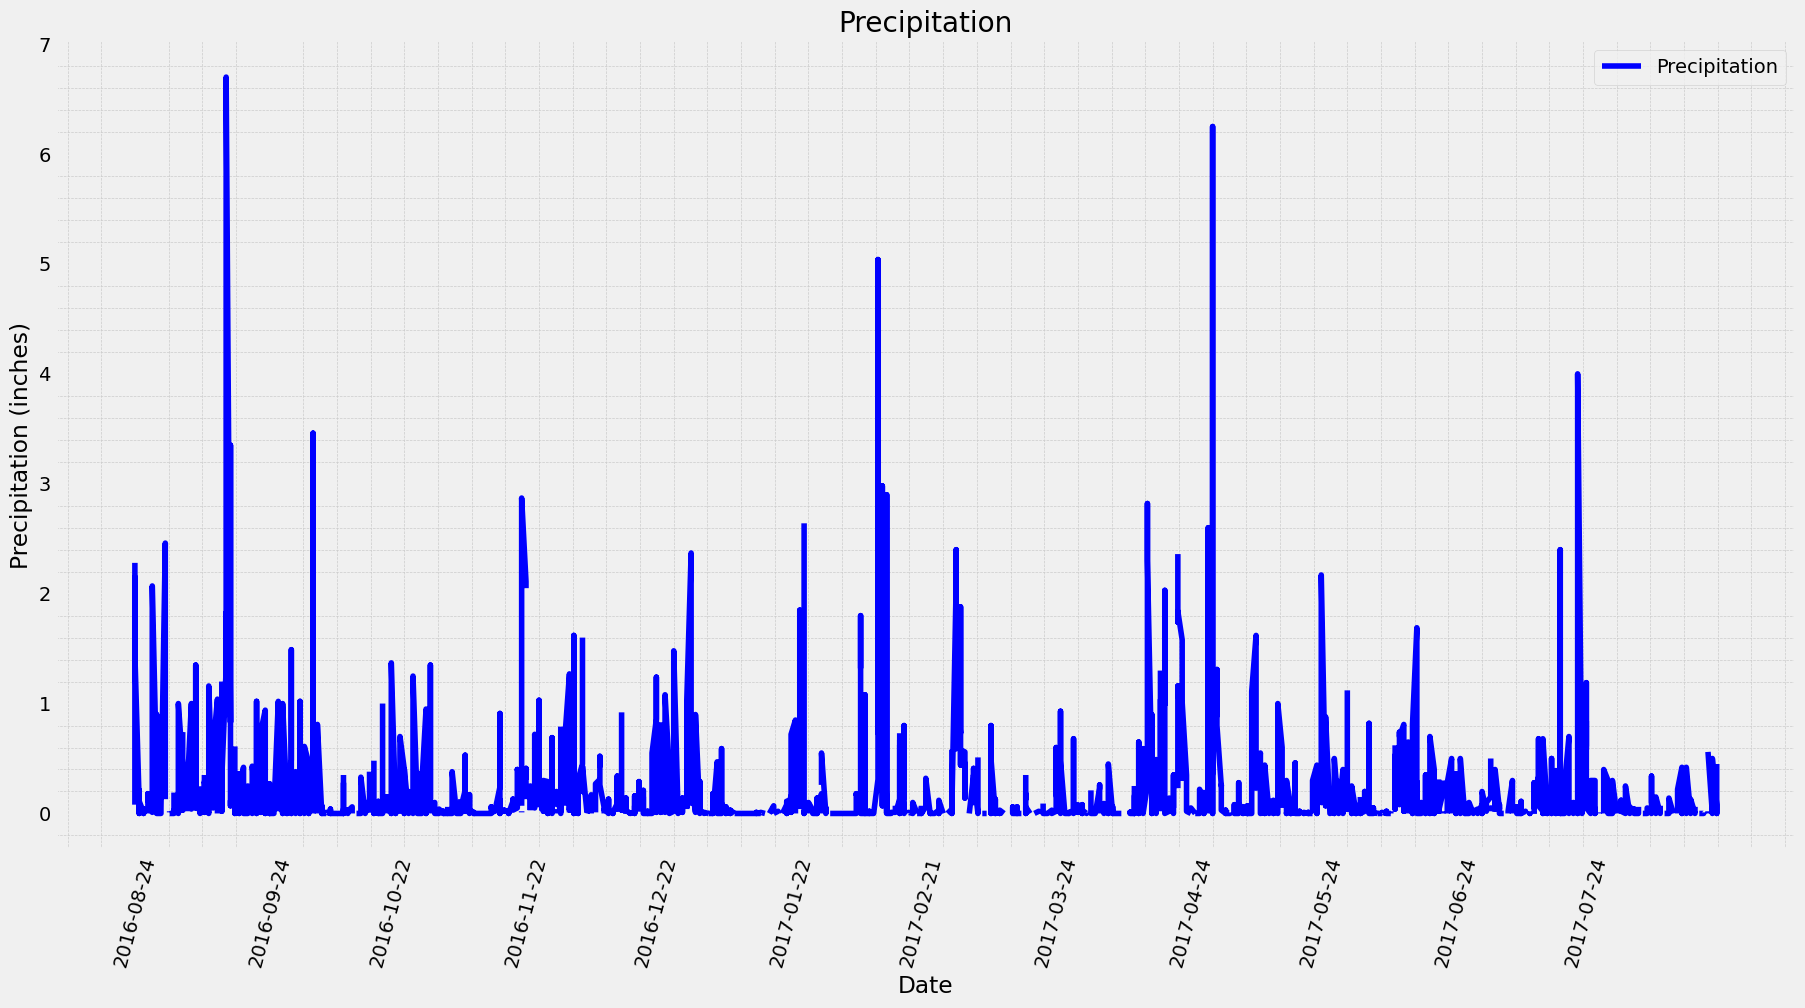

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
rec__
# Calculate the date one year from the last date in data set.
start_date = rec__ - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= start_date).\
    filter(measurement.date <= rec_date).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
querydf = pd.DataFrame(query, columns=['date', 'prcp'])

# Sort the dataframe by date
query_df = querydf.sort_values(by='date')
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(20, 10))
plt.plot(query_df['date'], query_df['prcp'], label='Precipitation', color='blue')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator())
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on() 
plt.xticks(rotation=75)
plt.grid(False)
plt.show()

In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats = query_df['prcp'].describe()
sum_stats

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number of stations in the dataset
total_stat = session.query(func.count(station.id)).scalar()
total_stat

9

In [24]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stat = (
    session.query(measurement.station, func.count(measurement.station))
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .all()
)

most_ac = (
    session.query(measurement.station, func.count(measurement.station))
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .first()
)

most_act = most_ac.station
# List the stations and their counts in descending order.
active_stat

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stat = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_act).all()
temp_stat

[(54.0, 85.0, 71.66378066378067)]

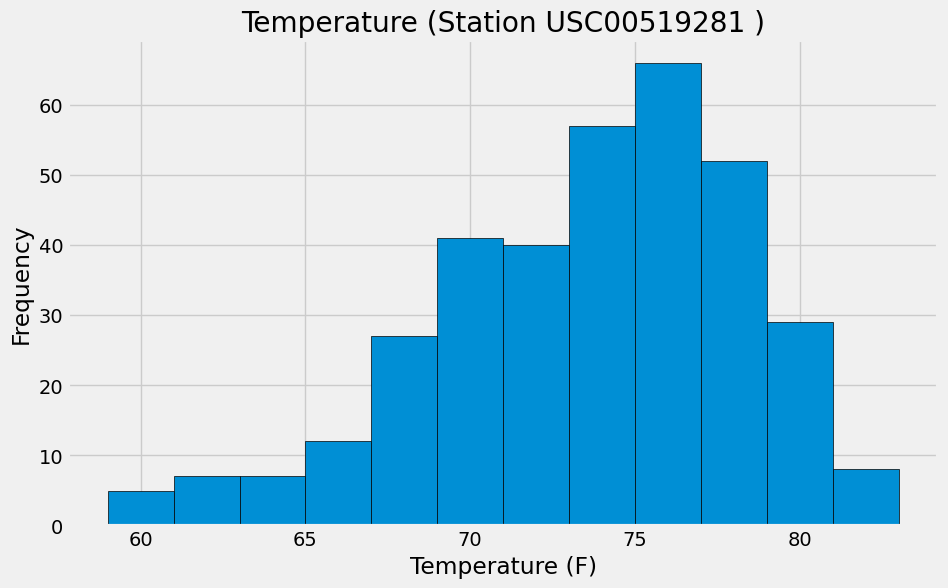

In [26]:
# Using the most active station id
most_act
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(measurement.tobs).\
    filter(measurement.station == most_act).\
    filter(measurement.date >= start_date).\
    filter(measurement.date <= rec_date).\
    order_by(measurement.date).all()

temp_df = pd.DataFrame(query, columns=['tobs'])


#plot
plt.figure(figsize=(10, 6))
plt.hist(temp_df['tobs'], bins=12, edgecolor='black')  # Adjust number of bins as needed
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature (Station {most_act} )')
plt.grid(True)
plt.show()

# Close Session

In [27]:
# Close Session
session.close()
